# **0. Importing Libraries**


In [1]:
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time

import torch
import torchvision
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **1. Data Loading**

**Paths**

In [2]:
example = '../input/oxford102-flower-dataset/Oxford102/flowers/1'
path = '../input/oxford102-flower-dataset/Oxford102/flowers'

**Let's take a quick look at the data. I don't know about you, but the first thing I always want to do is look at what our data looks like :)**

Shape: (500, 523, 3)


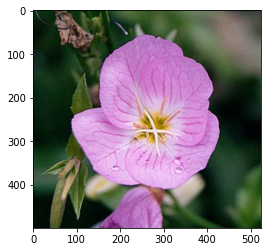

In [3]:
img = mpimg.imread(example + '/image_06734.jpg')
print('Shape:', img.shape)
plt.imshow(img);

**From the image above, you can understand that they are not normalized (which is very expected), how strong the spread can be seen using the script below:**

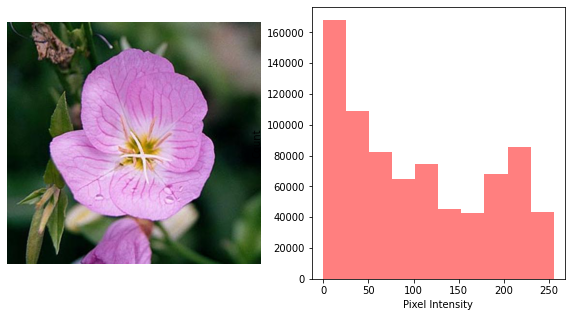

In [4]:
def plotHist(img):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.axis('off')
  histo = plt.subplot(1,2,2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Pixel Intensity')
  plt.hist(img.flatten(), bins=10, lw=0, alpha=0.5, color='r')

plotHist(img)

# **2. Data preparation**


**Let's write augmentation and normalization right away. Why are there four datasets?**

**(1)** The "original" dataset is the original dataset(wow), which we will split into two parts: test (20%) and training (80%).

**(2)** The dataset "dataset1" is a dataset with augmentation, which we will add to the training part of the original dataset to expand the data.

**(3)** The dataset "dataset2" is a dataset with augmentation, which we will add to the training part of the original dataset to expand the data.

**(4)** The dataset "dataset3" is a dataset with augmentation, which we will add to the training part of the original dataset to expand the data.


In [5]:
transformer = {
    'original': transform.Compose([
                                 transform.Resize((220, 220)),
                                 transform.ToTensor(), 
                                 transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), 
                                                     (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))
])    }

**pin_memory:** You know how sometimes your GPU memory shows that it’s full but you’re pretty sure that your model isn’t using that much? That overhead is called pinned memory. ie: this memory has been reserved as a type of “working allocation.”
When you enable pinned_memory in a DataLoader it “automatically puts the fetched data Tensors in pinned memory, and enables faster data transfer to CUDA-enabled GPUs”

**num_workers:** PyTorch allows loading data on multiple processes simultaneously. A good rule: ***num_worker = 4 * num_GPU***

In [6]:
bs = 50

original = ImageFolder(path, transform=transformer['original'])

#all_set = train_val + test
train_val, test = train_test_split(original, test_size=0.2, shuffle=True, random_state=43)

#train_val = train + val + dataset1 + dataset2 + dataset3
#train_val = ConcatDataset([train_val, 
 #                          ImageFolder(path, transform=transformer['dataset1'])])

train, val = train_test_split(train_val, test_size=0.1, shuffle=True, random_state=43)

loaders = {
    'train': DataLoader(train, batch_size=bs, num_workers=4, pin_memory=True),
    'val': DataLoader(val, batch_size=bs, num_workers=4, pin_memory=True),
    'test': DataLoader(test, batch_size=bs, num_workers=4, pin_memory=True)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val), 
    'test': len(test),
}

In [7]:
#loader = DataLoader(train_ds, batch_size=1000, num_workers=4)
# Normalisation values
channels_sum, channels_squared_sum, num_batches = 0, 0, 0
for data,_ in loaders['train']:
        # Mean over batch, height and width, but not over the channels
    channels_sum += torch.mean(data, dim=[0,2,3])
    channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
    num_batches += 1
    
mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
print('mean: ', mean)
print('Standard Deviation :', std)

mean:  tensor([0.0757, 0.0364, 0.1022])
Standard Deviation : tensor([0.9002, 0.8288, 0.9195])


**We have already normalized the data, but at this stage I would like to dwell in more detail, because this is very important.**

In datasets, we have three-channel images, that is, we need to normalize for each channel separately (!!!). Because of the unnormalized data, problems may appear, for example, regularization during training can work to the detriment, but we do not want this at all. The task of normalization is to make the mean as close to zero as possible, and the standard deviation around 1. 

How each channel looks separately can be seen below:

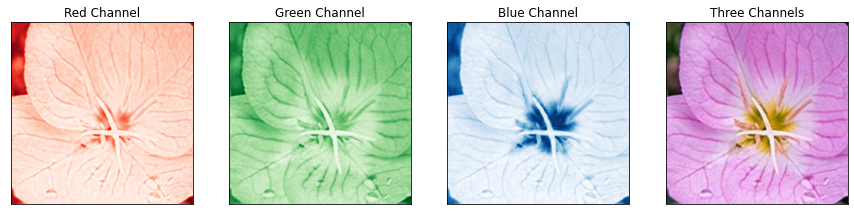

In [8]:
exampleset = ImageFolder(path, transform=transform.Compose([transform.ToTensor(),
                                                            transform.CenterCrop(255),]))

x, y = next(iter(DataLoader(exampleset)))

channels = ['Red', 'Green', 'Blue']
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for i, axs in enumerate(fig.axes[:3]):
    axs.imshow(x[0][i,:,:], cmap=cmaps[i])
    axs.set_title(f'{channels[i]} Channel')
    axs.set_xticks([])
    axs.set_yticks([])
    
ax[3].imshow(x[0].permute(1,2,0))
ax[3].set_title('Three Channels')
ax[3].set_xticks([])
ax[3].set_yticks([]);

**Now let's check how well we managed to normalize the data for each channel for the test, training and validation datasets:**

In [9]:
channels = 3

for channel in range(channels):
    for x in ['train', 'val', 'test']:
        #number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
        num_pxl = dataset_sizes[x]*220*220
    
        #we go through the butches and sum up the pixels of the objects, 
        #which then divide the sum by the number of all pixels to calculate the average
        total_sum = 0
        for batch in loaders[x]:
            layer = list(map(itemgetter(channel), batch[0]))
            layer = torch.stack(layer, dim=0)
            total_sum += layer.sum()
        mean = total_sum / num_pxl

        #we calculate the standard deviation using the formula that I indicated above
        sum_sqrt = 0
        for batch in loaders[x]: 
            layer = list(map(itemgetter(channel), batch[0]))
            sum_sqrt += ((torch.stack(layer, dim=0) - mean).pow(2)).sum()
        std = torch.sqrt(sum_sqrt / num_pxl)
        
        print(f'|channel:{channel+1}| {x} - mean: {mean}, std: {std}')

|channel:1| train - mean: 0.07563980668783188, std: 0.9001789093017578
|channel:1| val - mean: 0.06361239403486252, std: 0.8960773348808289
|channel:1| test - mean: 0.055875442922115326, std: 0.8983175158500671
|channel:2| train - mean: 0.036385975778102875, std: 0.8287774324417114
|channel:2| val - mean: 0.029744870960712433, std: 0.8233665823936462
|channel:2| test - mean: 0.03332599997520447, std: 0.8277627229690552
|channel:3| train - mean: 0.10214278101921082, std: 0.9194886684417725
|channel:3| val - mean: 0.1011531874537468, std: 0.9095594882965088
|channel:3| test - mean: 0.11047249287366867, std: 0.9274570345878601


**Let's take a batch from the training dataset and see its mean and standard deviation:**

In [10]:
x, y = next(iter(loaders['train']))
x.mean(),  x.std()

(tensor(0.0482), tensor(0.9128))

**Let's take a look at the pixel distribution after normalization. Compared to the distribution at the beginning, the difference is large**

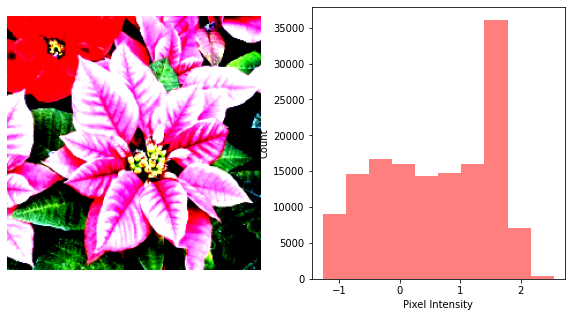

In [11]:
x, y = next(iter(loaders['train']))
img_norm = x[0].permute(1,2,0).numpy()
plotHist(img_norm)

**This is how we can look at our classes. There are only five of them, which is not much**

In [12]:
print('Classes:', original.classes)
print('Number of classes:', len(original.classes))

Classes: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
Number of classes: 102


**Let's check how imbalanced our data is. Since we are working with images, first we need to make a pandas table, and then render the table.**

In [13]:
dic = {}

for classes in original.classes:
  dic[classes] = [len([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)])]

samplesize = pd.DataFrame.from_dict(dic)

In [14]:
samplesize

,1,10,100,101,102,11,12,13,14,15,...,90,91,92,93,94,95,96,97,98,99
0,40,45,49,58,48,87,87,49,48,49,...,82,76,66,46,162,128,91,66,82,63


**The imbalance is small and we do not need to handle it in any way, since the ratio of the largest class to the smallest is 1.47, which is not much**

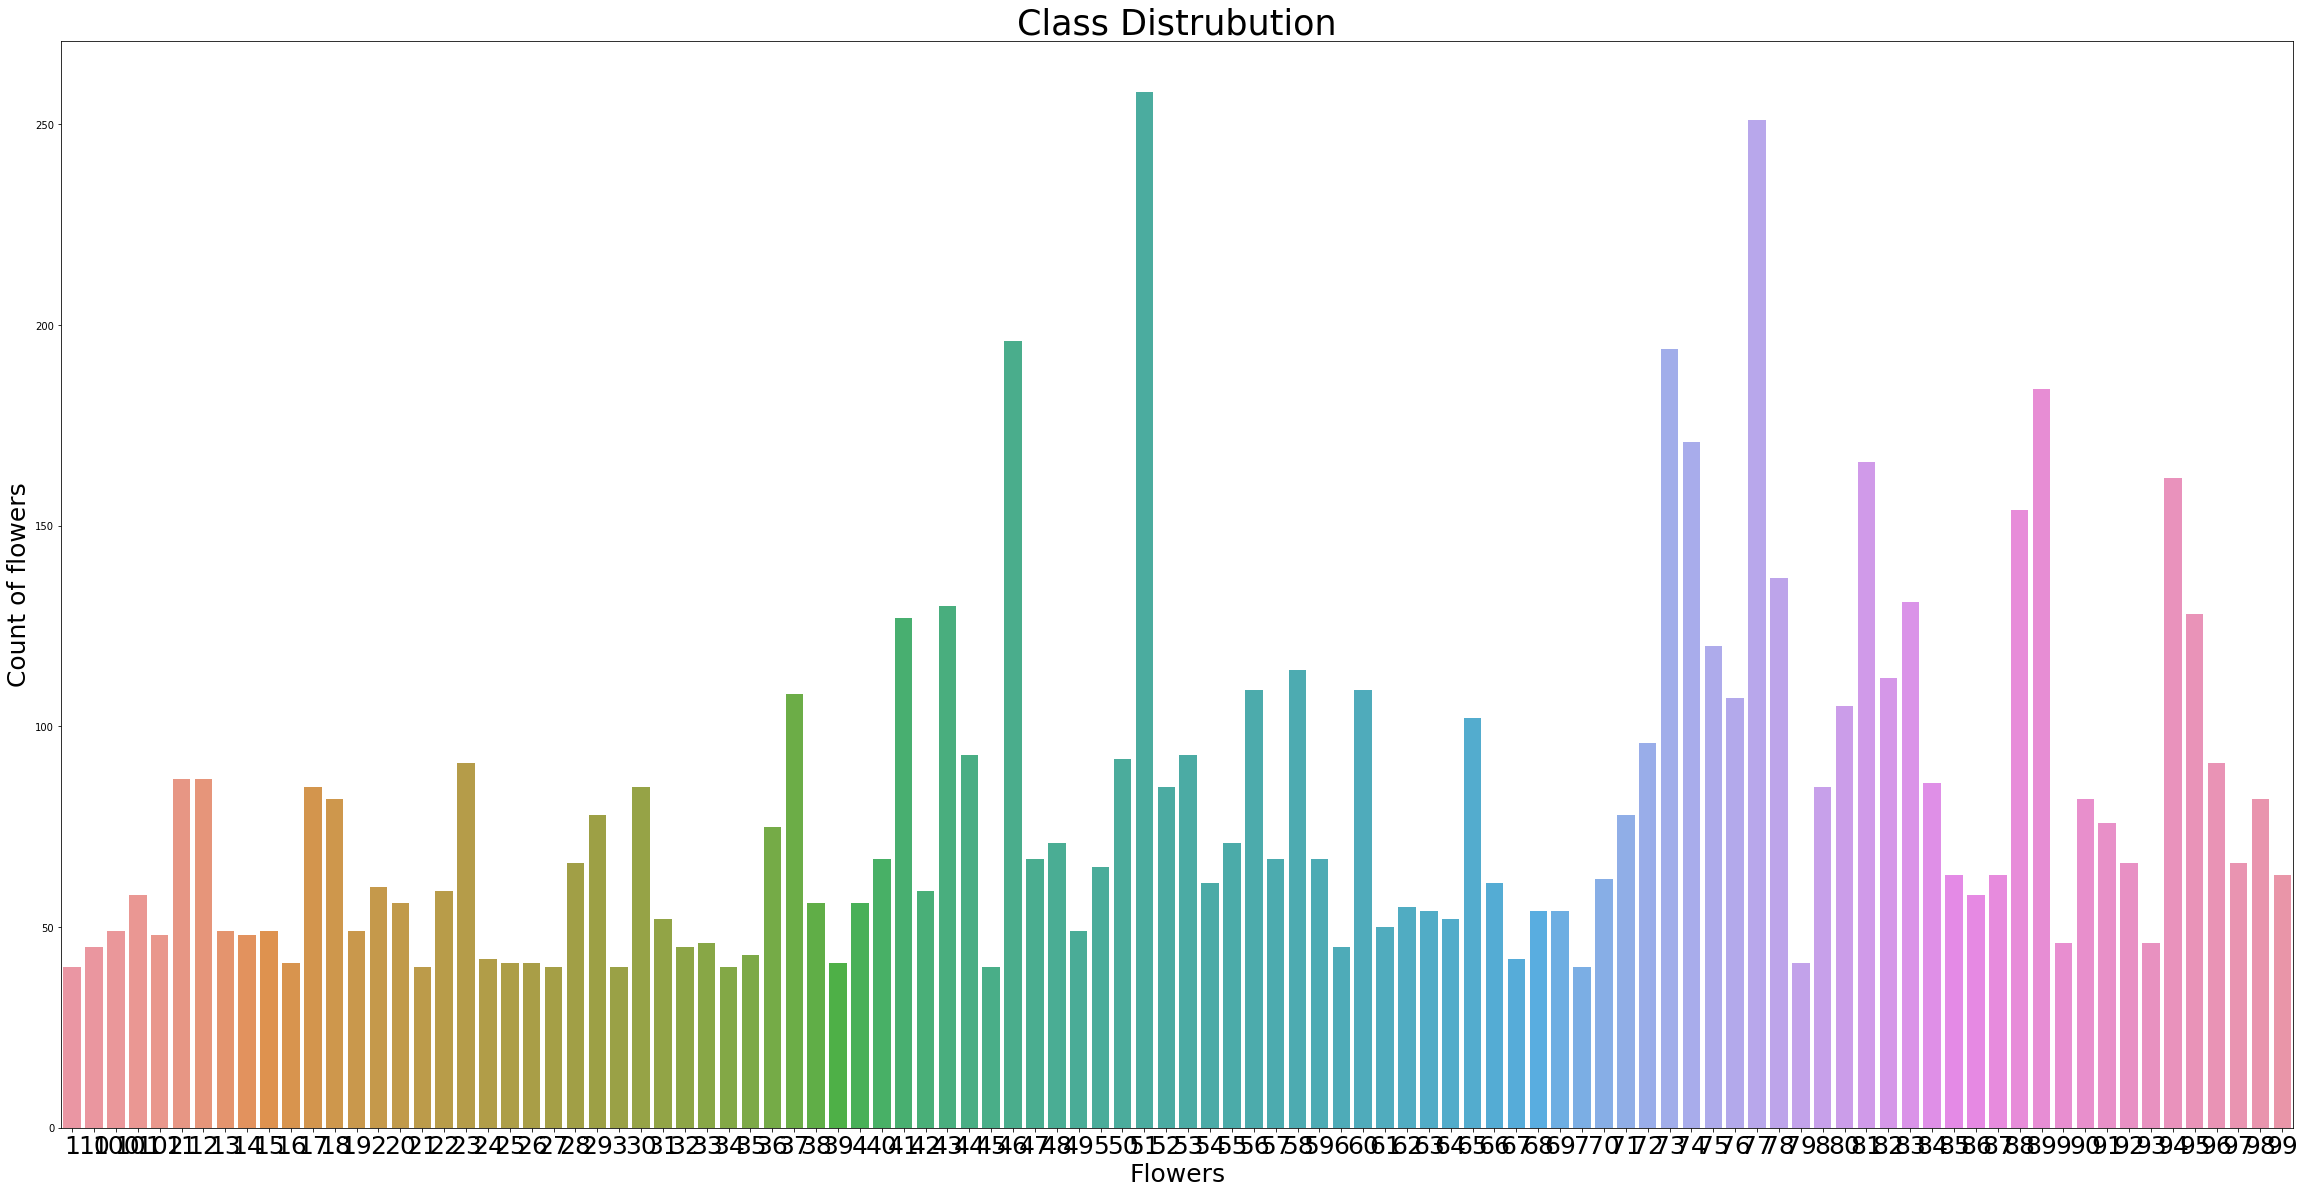

In [15]:
figure_size = plt.rcParams['figure.figsize']
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams['figure.figsize'] = figure_size

sns.barplot(data=samplesize)

index = np.arange(len(original.classes))

plt.xlabel('Flowers', fontsize=25)
plt.ylabel('Count of flowers', fontsize=25)
plt.xticks(index, original.classes, fontsize=25)
plt.title('Class Distrubution', fontsize=35)
plt.show()

**Let's see how the images from the original dataset look like without changes:**

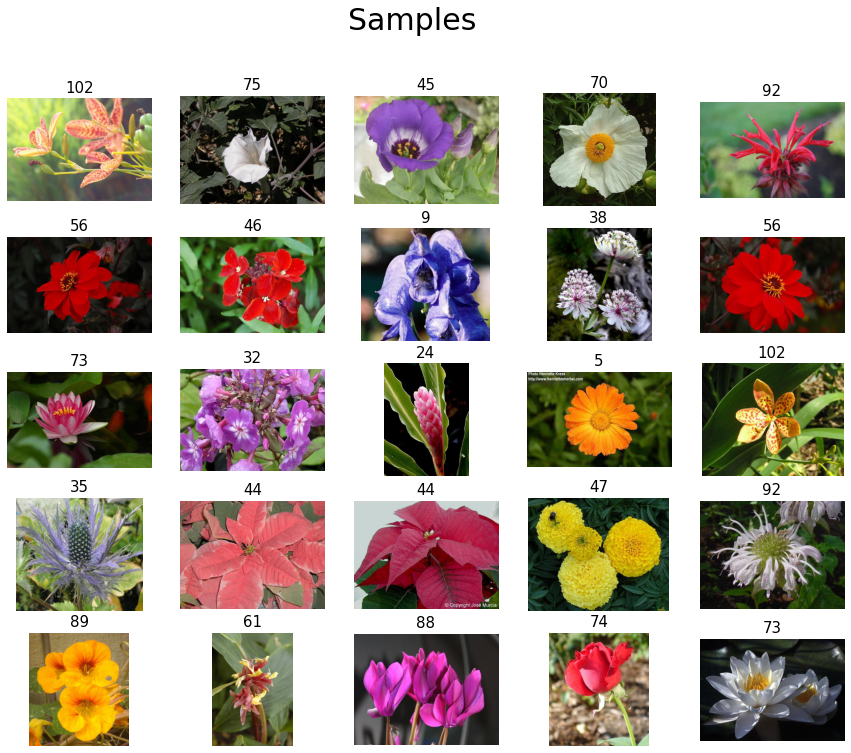

In [16]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = mpimg.imread(samples[i][0][0])
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1
  

rand_samples = [] 
for _ in range(25): 
    classes = random.choice(original.classes)
    rand_samples.append([random.sample([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)], 1), classes]) 
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Samples', fontsize=30)
plt.show()

**And this is how images with augmentation look like**

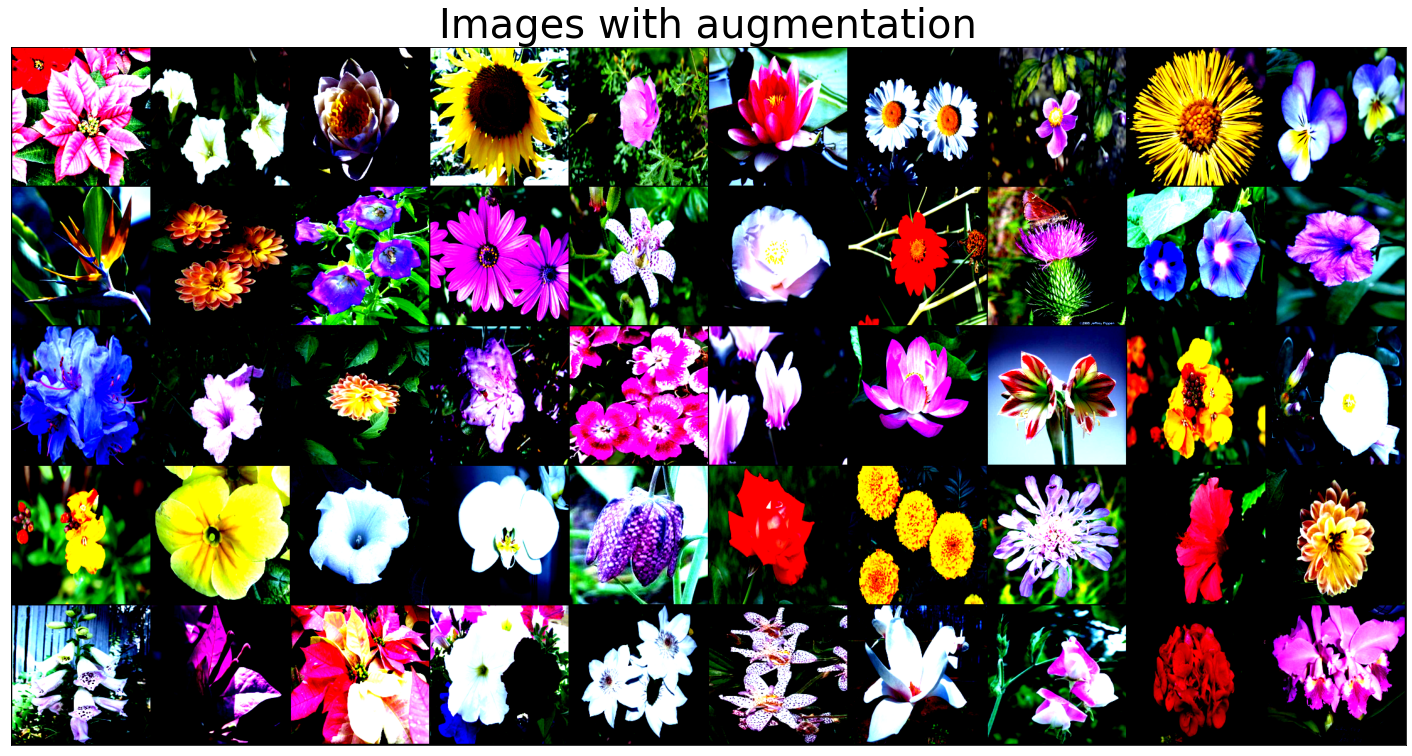

In [17]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        ax.set_title('Images with augmentation', fontsize=40)
        break
        
show_batch(loaders['train'])

# 3. Training and Test

**Idea:** I will use an ensemble of pre-trained models. I first train only the classifier on 10 epochs, then unfreeze the network and train all together for another 10 epochs

In order not to count the accuracy many times, we write the function

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

**This is where we will record the history of learning, so that we can make visualization later. We need visualization to evaluate learning, for example, overfitting or underfitting. Of course, we can analyze with numbers, but it is much easier to perceive information visually**

In [19]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
lr = []

Train function structure:

1. **Classifier Training**
2. **Network-wide Training**

In [20]:
def train(seed, epochs, model):

    print("Creating a model {}...".format(seed))

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    if  seed==2 or seed==3:
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001,
                betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
    else:
        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
            mode="max", factor=0.1, patience=3, verbose=True)

  # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.1, epochs=epochs, steps_per_epoch=len(loaders["train"]), cycle_momentum=True)
  # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)

    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for (inputs, labels) in loaders[phase]:
                (inputs, labels) = (inputs.to(device),
                                    labels.to(device))
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outp = model(inputs)
                    (_, pred) = torch.max(outp, 1)
                    loss = criterion(outp, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

#             lr.append(scheduler.get_lr())
#             scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

            if phase == "train":
                acc = 100. * running_corrects.double() \
                    / dataset_sizes[phase]
                scheduler.step(acc)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if phase == "train":
                print("Epoch: {}/{}".format(epoch + 1, epochs))
            print("{} - loss:{}, accuracy{}".format(phase, epoch_loss,
                    epoch_acc))
            lr.append(scheduler._last_lr)

            if phase == "val":
                print("Time: {}m {}s".format((time.time() - since)
                        // 60, (time.time() - since) % 60))
                print("==" * 31)
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

    # scheduler.step()

    time_elapsed = time.time() - since
    print("CLASSIFIER TRAINING TIME {}m {}s".format(time_elapsed // 60, time_elapsed % 60))
    print("==" * 31)

    model.load_state_dict(best_model)

    for param in model.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,
                                 betas=(0.9, 0.999), eps=1e-08,
                                 weight_decay=0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
            factor=0.1, patience=1, verbose=True)

  # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
  # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.001, epochs=epochs, steps_per_epoch=len(loaders["train"]), cycle_momentum=True)

    for epoch in range(epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for (inputs, labels) in loaders[phase]:
                (inputs, labels) = (inputs.to(device),
                                    labels.to(device))

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outp = model(inputs)
                    (_, pred) = torch.max(outp, 1)
                    loss = criterion(outp, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

#             lr.append(scheduler.get_lr())
#             scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

            if phase == "train":
                acc = 100. * running_corrects.double() \
                    / dataset_sizes[phase]
                scheduler.step(acc)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if phase == "train":
                print("Epoch: {}/{}".format(epoch + 1, epochs))
            print("{} - loss:{}, accuracy{}".format(phase, epoch_loss,
                    epoch_acc))
            lr.append(scheduler._last_lr)

            if phase == "val":
                print("Time: {}m {}s".format((time.time() - since)
                        // 60, (time.time() - since) % 60))
                print("==" * 31)
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

    # scheduler.step()

    time_elapsed = time.time() - since
    print("ALL NET TRAINING TIME {}m {}s".format(time_elapsed // 60,
            time_elapsed % 60))
    print("==" * 31)

    model.load_state_dict(best_model)
    return model

# MODELS

**1. DenseNet(1)**

In [21]:
densenet121_0 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_0.parameters():
  param.requires_grad=False

densenet121_0.classifier = nn.Linear(in_features=densenet121_0.classifier.in_features, out_features=len(original.classes), bias=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

**2. DenseNet121(2)**

In [22]:
densenet121_1 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_1.parameters():
  param.requires_grad=False

densenet121_1.classifier = nn.Linear(in_features=densenet121_1.classifier.in_features, out_features=len(original.classes), bias=True)

**3. GoogleNet**

In [23]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
  param.grad_requires = False

googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=len(original.classes), bias=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

**4. ResNet**

In [24]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
  param.grad_requires = False

resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=len(original.classes), bias=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

**5. VGG19**

In [25]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
  param.grad_requires = False

vgg19_bn.classifier[6] = nn.Linear(4096, len(original.classes), bias=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

**Launching training**

In [26]:
num_models = 5
epochs = 10

models = [densenet121_0, densenet121_1, googlenet, resnet101, vgg19_bn]

for seed in range(num_models):
   train(seed=seed, epochs=epochs, model=models[seed])

Creating a model 0...
Epoch: 1/10
train - loss:2.7488719874059275, accuracy0.495843935538592
val - loss:1.3516910857543714, accuracy0.7987804878048781
Time: 0.0m 20.090495586395264s
Epoch: 2/10
train - loss:0.8768349697875006, accuracy0.9019508057675997
val - loss:0.7446986938395151, accuracy0.8856707317073171
Time: 0.0m 34.306655406951904s
Epoch: 3/10
train - loss:0.4675718186718615, accuracy0.95284139100933
val - loss:0.5578267073667631, accuracy0.9039634146341464
Time: 0.0m 48.9363169670105s
Epoch: 4/10
train - loss:0.30642979601563997, accuracy0.9716709075487702
val - loss:0.4685989584682918, accuracy0.9085365853658537
Time: 1.0m 3.3465383052825928s
Epoch: 5/10
train - loss:0.2189591144408282, accuracy0.9850720949957591
val - loss:0.41678370648949614, accuracy0.913109756097561
Time: 1.0m 17.52468776702881s
Epoch: 6/10
train - loss:0.16427293386977038, accuracy0.991518235793045
val - loss:0.3833309425631674, accuracy0.9146341463414634
Time: 1.0m 32.04654788970947s
Epoch: 7/10
train 

# 4. Loss and Accuracy Plots

**As you can see from the graphs, the unfreeze idea worked. We can see that after the red lines, the performance improves!**

In [27]:
accuracies_train = [item.to("cpu").numpy() for item in accuracies['train']]
accuracies_val = [item.to("cpu").numpy() for item in accuracies['val']]

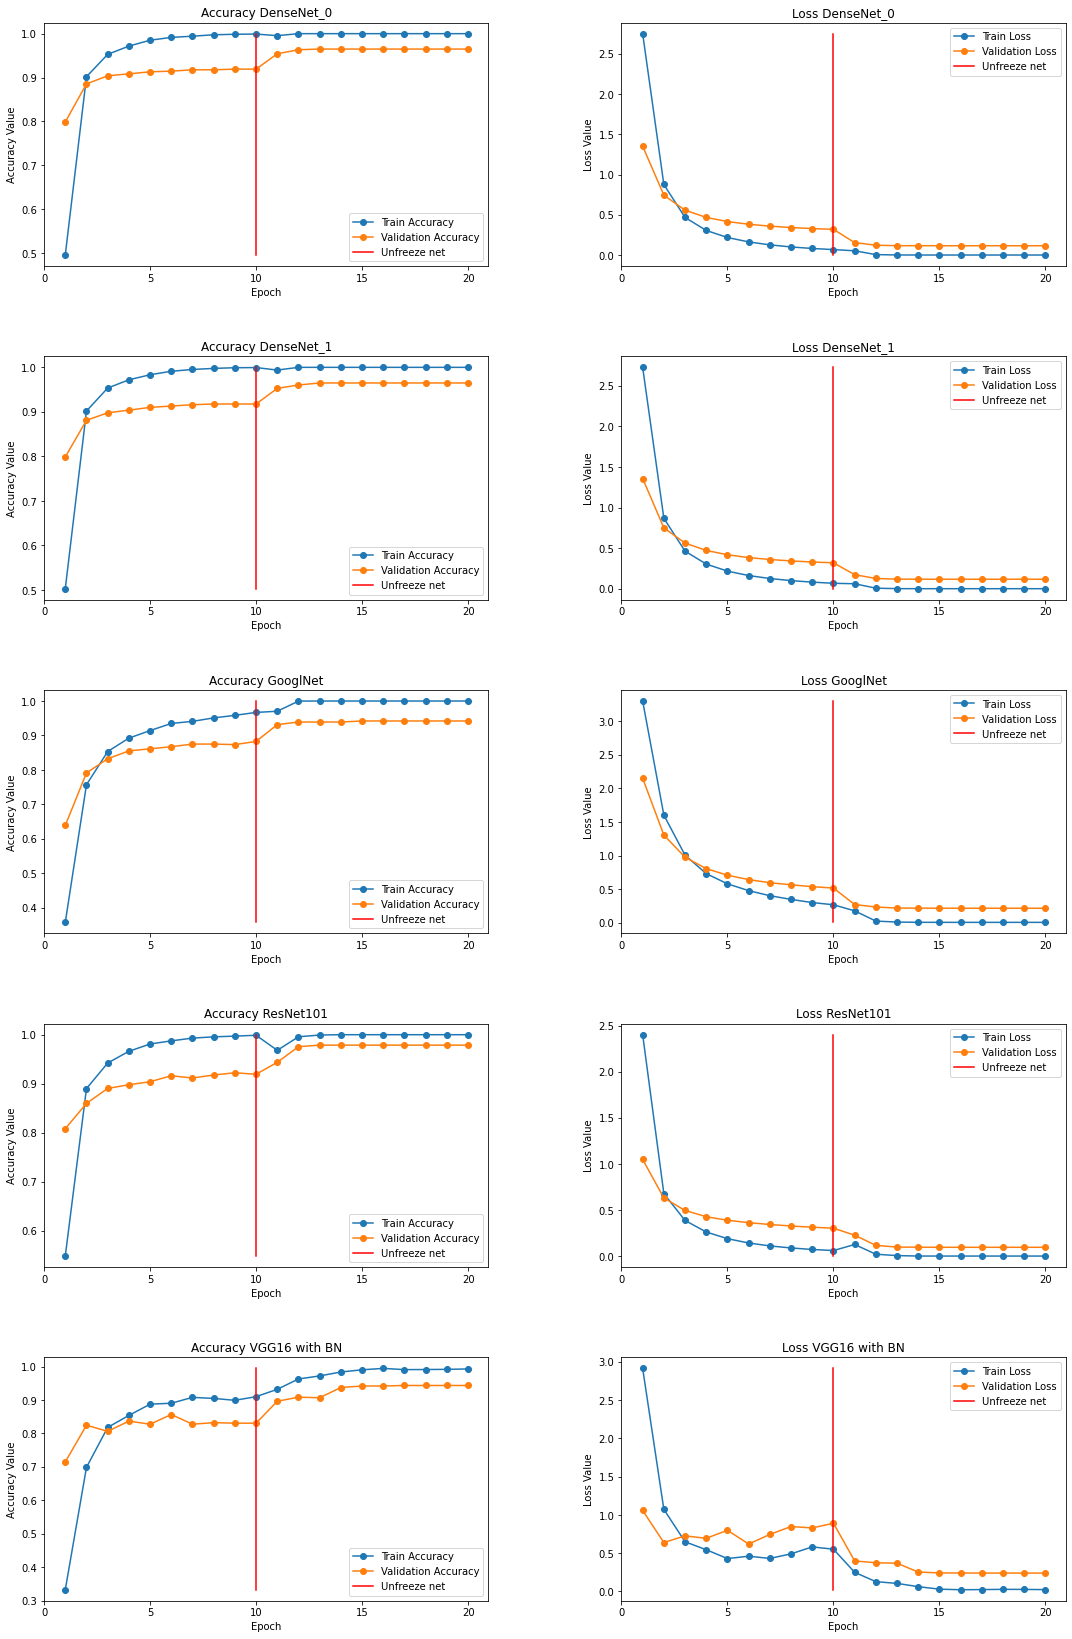

In [28]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
modelname = ['DenseNet_0', 'DenseNet_1', 'GooglNet', 'ResNet101', 'VGG16 with BN']

i=0

for row in range(5):

    epoch_list = list(range(1,epochs*2+1))

    ax[row][0].plot(epoch_list, accuracies_train[i:20+i], '-o', label='Train Accuracy')
    ax[row][0].plot(epoch_list, accuracies_val[i:20+i], '-o', label='Validation Accuracy')
    ax[row][0].plot([epochs for x in range(20)],  np.linspace(min(accuracies['train'][i:20+i]).cpu(), max(accuracies['train'][i:20+i]).cpu(), 20), color='r', label='Unfreeze net')
    ax[row][0].set_xticks(np.arange(0, epochs*2+1, 5))
    ax[row][0].set_ylabel('Accuracy Value')
    ax[row][0].set_xlabel('Epoch')
    ax[row][0].set_title('Accuracy {}'.format(modelname[row]))
    ax[row][0].legend(loc="best")

    ax[row][1].plot(epoch_list, losses['train'][i:20+i], '-o', label='Train Loss')
    ax[row][1].plot(epoch_list, losses['val'][i:20+i], '-o',label='Validation Loss')
    ax[row][1].plot([epochs for x in range(20)], np.linspace(min(losses['train'][i:20+i]), max(losses['train'][i:20+i]), 20), color='r', label='Unfreeze net')
    ax[row][1].set_xticks(np.arange(0, epochs*2+1, 5))
    ax[row][1].set_ylabel('Loss Value')
    ax[row][1].set_xlabel('Epoch')
    ax[row][1].set_title('Loss {}'.format(modelname[row]))
    ax[row][1].legend(loc="best")
    fig.tight_layout()
    fig.subplots_adjust(top=1.5, wspace=0.3)

    i+=20


# 5. Test set predictions

**First, let's write an ensemble class. It's very easy!**

In [29]:
class Ensemble(nn.Module):
    def __init__(self, device):
        super(Ensemble,self).__init__()
        # you should use nn.ModuleList. Optimizer doesn't detect python list as parameters
        self.models = nn.ModuleList(models)
        
    def forward(self, x):
        # it is super simple. just forward num_ models and concat it.
        output = torch.zeros([x.size(0), len(original.classes)]).to(device)
        for model in self.models:
            output += model(x)
        return output

In [30]:
model =  Ensemble(device)

**These functions will help us when calculating the accuracy**

In [31]:
def validation_step(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)                                      
        loss = F.cross_entropy(out, labels)                    
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}

In [32]:
def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}

In [33]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

**It seems to me that we have achieved good enough accuracy**

In [34]:
model.to(device)
preds,labels = test_predict(model, loaders['test'])

test_loss: 0.2299, test_acc: 0.9806


# 6. Predictions in individual images

**The function below will normalize the image back to its original. It simply multiplies the tensor by the standard deviation and adds the mean**

In [35]:
def norm_out(img):
    
    img = img.permute(1,2,0)
    mean = torch.FloatTensor([0.4124234616756439, 0.3674212694168091, 0.2578217089176178])
    std = torch.FloatTensor([0.3268945515155792, 0.29282665252685547, 0.29053378105163574])
    
    img = img*std + mean
        
    return np.clip(img,0,1)

**In random pictures, the network shows 100% accuracy, this is the most confident answer, so you can make the assumption that the networks have learned well**

# 7. Metrics

In [36]:
report = classification_report(labels, preds,
                               output_dict=True,
                               target_names=original.classes)
report_df = pd.DataFrame(report).transpose()

In [37]:
pd.set_option("display.max_rows", None)
report_df.head(134)

,precision,recall,f1-score,support
1,1.000000,0.857143,0.923077,7.000000
10,1.000000,1.000000,1.000000,10.000000
100,1.000000,1.000000,1.000000,9.000000
101,1.000000,1.000000,1.000000,10.000000
102,1.000000,1.000000,1.000000,9.000000
11,1.000000,0.950000,0.974359,20.000000
12,1.000000,1.000000,1.000000,21.000000
13,1.000000,1.000000,1.000000,14.000000
14,1.000000,1.000000,1.000000,13.000000
15,1.000000,1.000000,1.000000,8.000000


<Figure size 2880x1440 with 0 Axes>

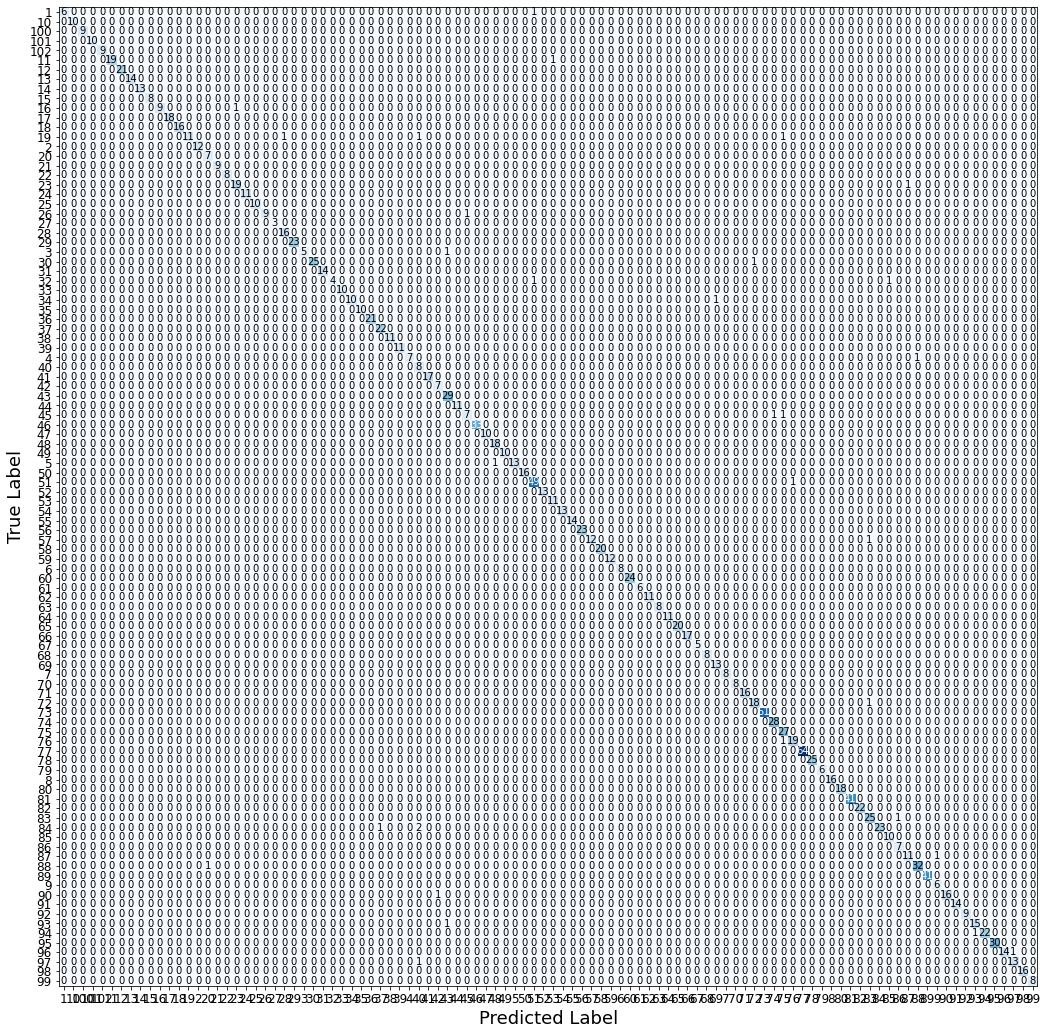

In [38]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(18,18),cmap=plt.cm.Blues)
plt.xticks(range(len(original.classes)), original.classes, fontsize=12)
plt.yticks(range(len(original.classes)), original.classes, fontsize=12)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()